In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator, clone
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

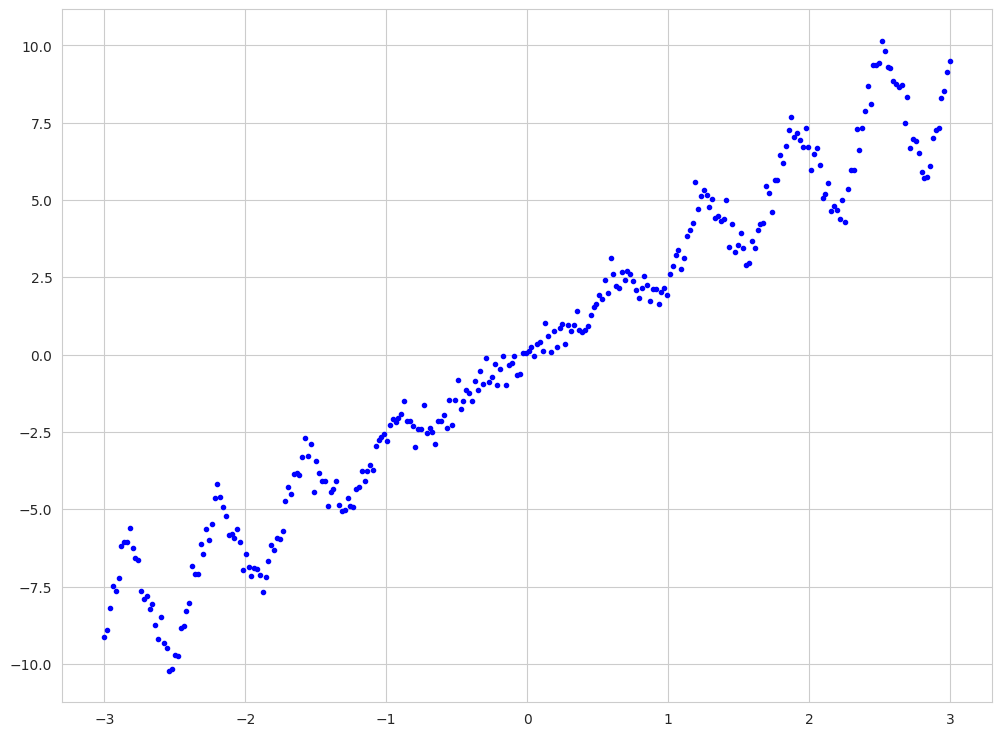

In [15]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [16]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

Будем увеличивать глубину, пока дерево не станет неустойчивым. Устойчивость предсказаний будем оценивать, отрисовывая предсказания для 100 подвыборок из наших данных.

In [18]:
n_repeat = 1000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)
error = []
depth_mean = []
# Loop over estimators to compare
for n in range(1, 20 + 1):
    # Compute predictions
    y_predicts, depths = [], []

    for i in range(n_repeat):
        X_subtrain, _, y_subtrain, _ = train_test_split(X_train, y_train, test_size=0.1)
        estimator = DecisionTreeRegressor(max_depth=n)
        estimator.fit(X_subtrain, y_subtrain)
        y_predicts.append(estimator.predict(X_test))
        depths.append(estimator.tree_.max_depth)

    y_predicts = np.array(y_predicts)
    # Bias^2 + Variance + Noise decomposition of the mean squared error
    bias = np.mean((y_predicts - y_test.reshape(-1)[None, :])**2)
    variance = np.mean(np.var(y_predicts, axis=0))
    print("i =", n, bias, variance, np.array(depths).mean())
    error.append(bias**2 + variance**2)
    depth_mean.append(np.array(depths).mean())

i = 1 10.934902016655913 0.01919737532130323 1.0
i = 2 2.131210200138453 0.2600827732372504 2.0
i = 3 3.942442188146572 0.02693548995588184 3.0
i = 4 3.342008241614233 0.32480976154459046 4.0
i = 5 2.4970508588852054 0.10512753963095212 5.0
i = 6 2.511170957259647 0.06649094242133914 6.0
i = 7 2.5813037385550723 0.05454909205167004 7.0
i = 8 2.582120616528009 0.05467952526625973 8.0
i = 9 2.577172652340043 0.05460981689500963 9.0
i = 10 2.5643890351052634 0.05875700746746648 10.0
i = 11 2.5623291913568607 0.058352417638566606 11.0
i = 12 2.568410039535845 0.05953420627154962 12.0
i = 13 2.573089430390274 0.058811579308743506 12.886
i = 14 2.567867090649065 0.05778890115647937 13.131
i = 15 2.5811376808712647 0.05204868900259963 13.166
i = 16 2.565030667058267 0.06052859698130387 13.13
i = 17 2.5356893278462387 0.06924323500520294 13.16
i = 18 2.566060588932468 0.060730852142361055 13.229
i = 19 2.54509357260344 0.06632847781923992 13.174
i = 20 2.5658664439718697 0.06151545076073684 13

Видно, что при глубине дерева большей 12 алгоритм сходится раньше достижения последнего уровня. Таким образом, хорошим предсказателем является дерево с глубиной 12.

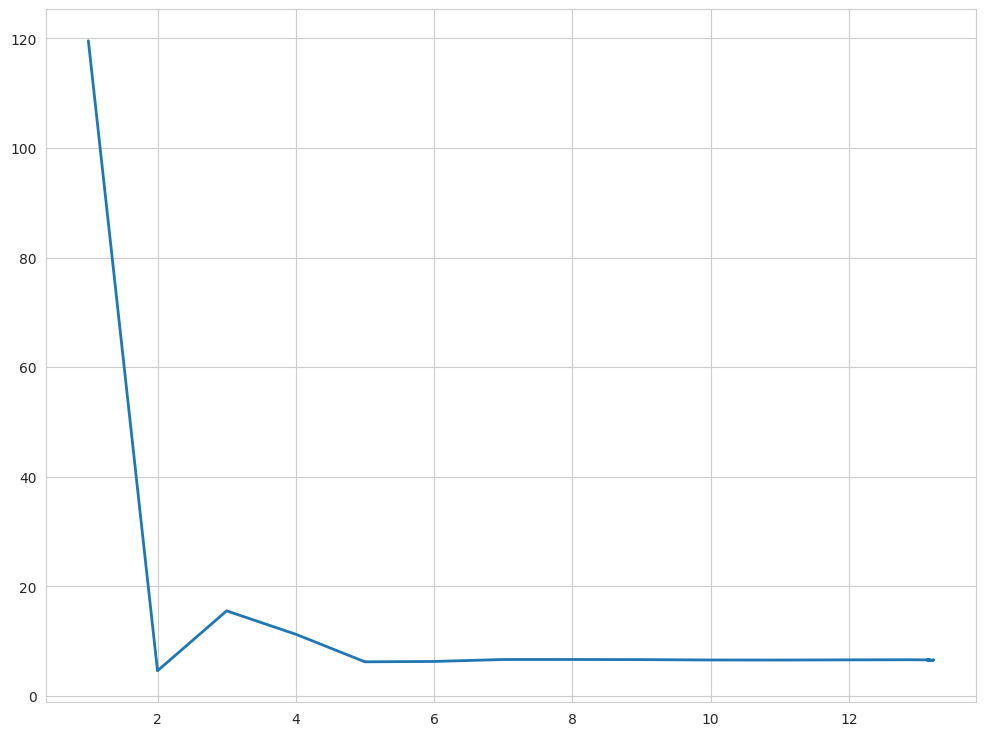

In [19]:
plt.plot(depth_mean, error, linewidth=2)
plt.show()

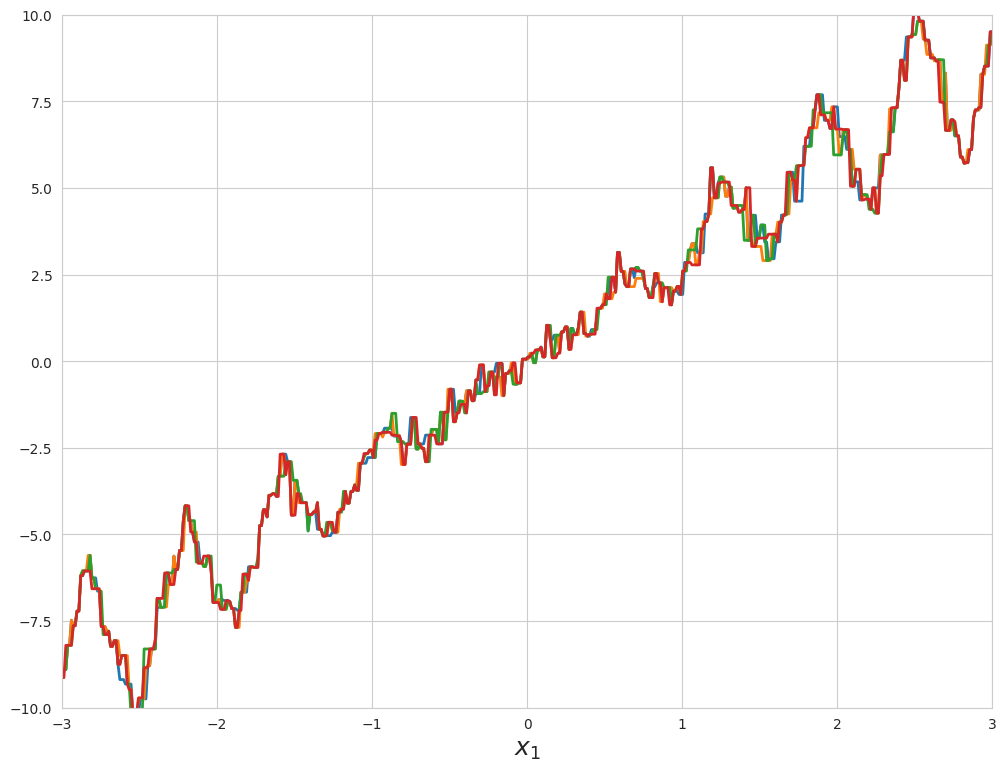

In [20]:
estimator = DecisionTreeRegressor(max_depth=12)
x1 = np.linspace(-3, 3, 500).reshape(-1, 1)
plt.axis([-3, 3, -10, 10])
plt.xlabel("$x_1$", fontsize=18)
for _ in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(x1)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [21]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

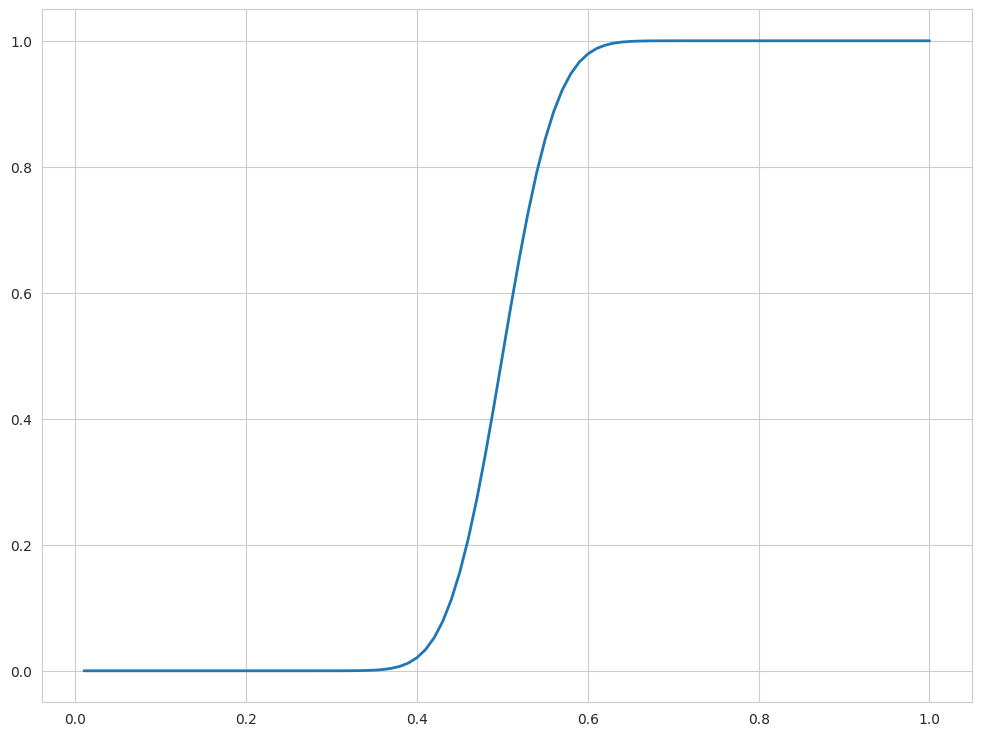

In [22]:
p_list = [p / 100 for p in range(1, 101)]
mu = []
for p in p_list:
    cur_mu = 0
    for i in range(51, 102):
        cur_mu += math.comb(101, i) * p**i * (1 - p)**(101 - i)
    mu.append(cur_mu)

plt.plot(p_list, mu, linewidth=2)

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [23]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

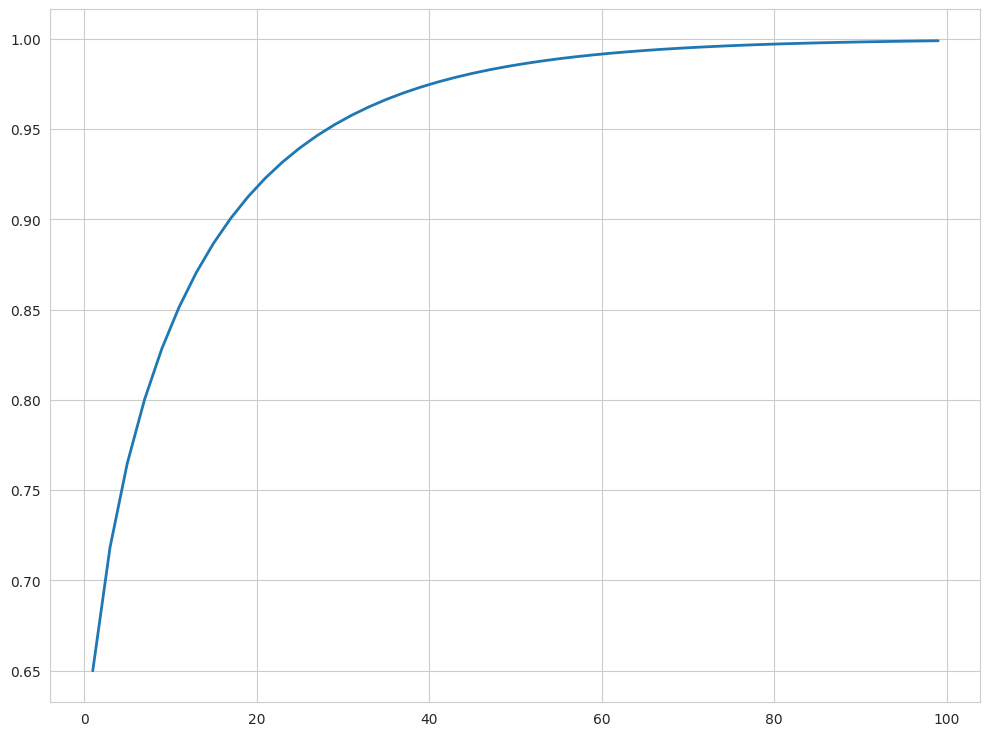

In [181]:
p = 0.65
n_models = range(1, 101, 2)
mu = []
for n in n_models:
    cur_mu = 0
    for i in range(n // 2 + 1, n + 1):
        cur_mu += math.comb(n, i) * p**i * (1 - p)**(n - i)
    mu.append(cur_mu)

plt.plot(n_models, mu, linewidth=2)

Опишите ваши наблюдения:

* На первом графике мы видим, что для большого числа моделей (101), правильность предсказания становится очень чувствительной к вероятности правильной классификации для каждой модели. Так, при `p = 0.4` вероятность правильного предсказания становится меньше 5%. В то же время, при `p = 0.6` вероятность правильного предсказания становится больше 95%.
* Из второго графика можно сделать вывод, что при `p > 0.5` при увеличении количества моделей, увеличивается вероятность правильного предсказания.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [25]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))

        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            self.feat_ids_by_tree.append(random.sample(range(X.shape[1]), self.max_features)) #Warning
            poses = np.random.choice(X.shape[0], size=X.shape[0],
                                     replace=True)
            x_boot = X[poses, :][:, self.feat_ids_by_tree[i]]
            y_boot = y[poses]
            clf = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state)
            clf.fit(x_boot, y_boot)
            self.trees.append(clf)
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

        all_proba = []
        for i in range(self.n_estimators):
            all_proba.append(self.trees[i].predict_proba(X[:, self.feat_ids_by_tree[i]]))
        return np.array(all_proba).mean(axis=0)

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [26]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

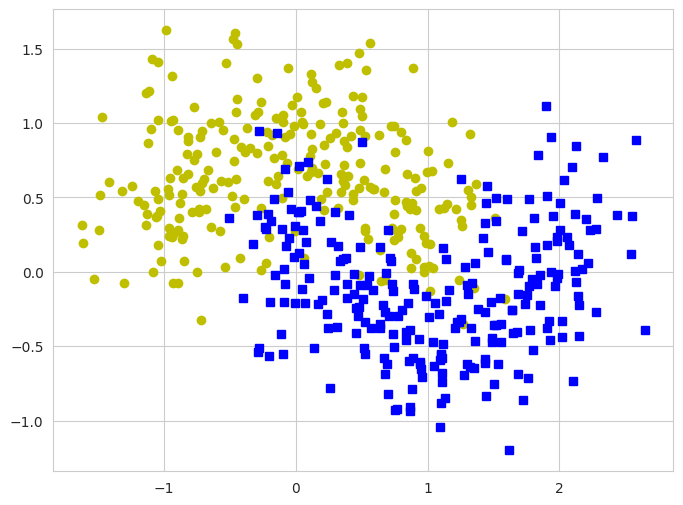

In [27]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [28]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

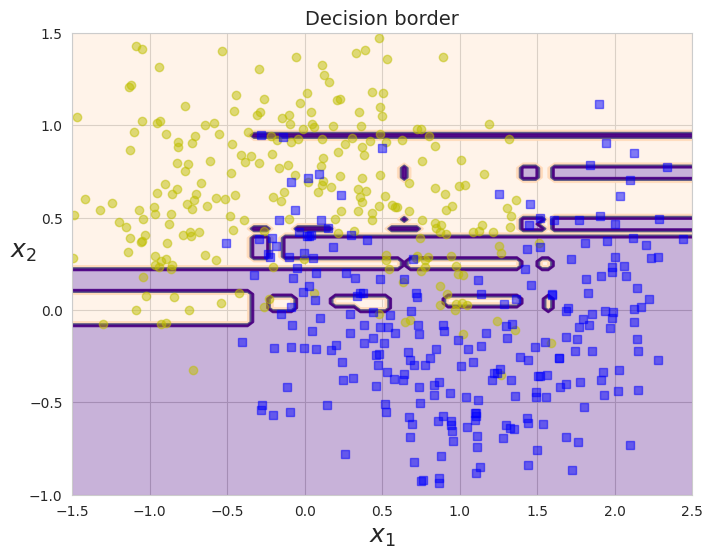

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(n_estimators = 5, max_depth=5, max_features=1)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [36]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [42]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

max_f1_score = 0
for n_features in range(1, X.shape[1] + 1):
    for depth in range(1, 30):
        for n_tree in range(1, 20):
            clf = RandomForestClassifierCustom(n_estimators = n_tree, max_depth=depth, max_features=n_features)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1_score_ = f1_score(y_test, y_pred)
            if f1_score_ > max_f1_score:
                print(n_features, depth, n_tree, "\nAccuracy:", accuracy_score(y_test, y_pred), "\nF1 score:", f1_score_, "\nRecall:", recall_score(y_test, y_pred), "\nPrecision:", precision_score(y_test, y_pred), "\n")
                max_f1_score = f1_score_

1 1 1 
Accuracy: 0.768 
F1 score: 0.7339449541284403 
Recall: 0.6666666666666666 
Precision: 0.8163265306122449 

1 1 7 
Accuracy: 0.816 
F1 score: 0.7964601769911505 
Recall: 0.75 
Precision: 0.8490566037735849 

1 1 12 
Accuracy: 0.864 
F1 score: 0.8571428571428572 
Recall: 0.85 
Precision: 0.864406779661017 

1 1 17 
Accuracy: 0.904 
F1 score: 0.8947368421052632 
Recall: 0.85 
Precision: 0.9444444444444444 

2 4 9 
Accuracy: 0.912 
F1 score: 0.9075630252100839 
Recall: 0.9 
Precision: 0.9152542372881356 



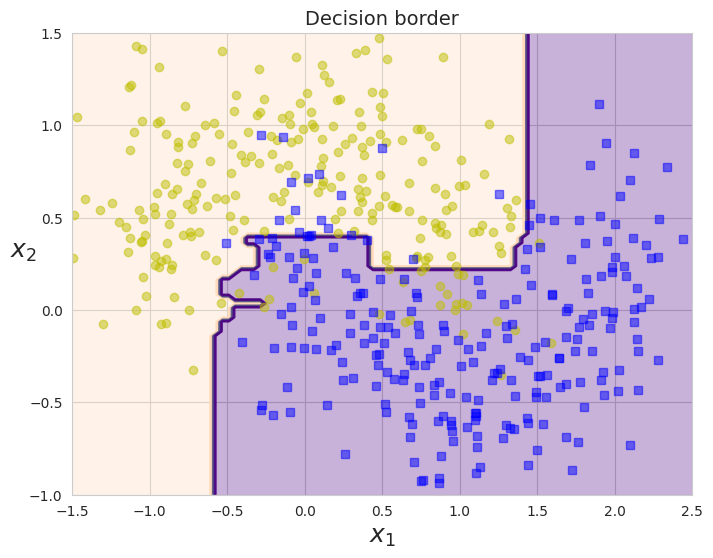

In [43]:
plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(n_estimators = 9, max_depth=4, max_features=2)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Подобранные гиперпараметры: `n_estimators = 9, max_depth=4, max_features=2`.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [73]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [74]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

569

In [75]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

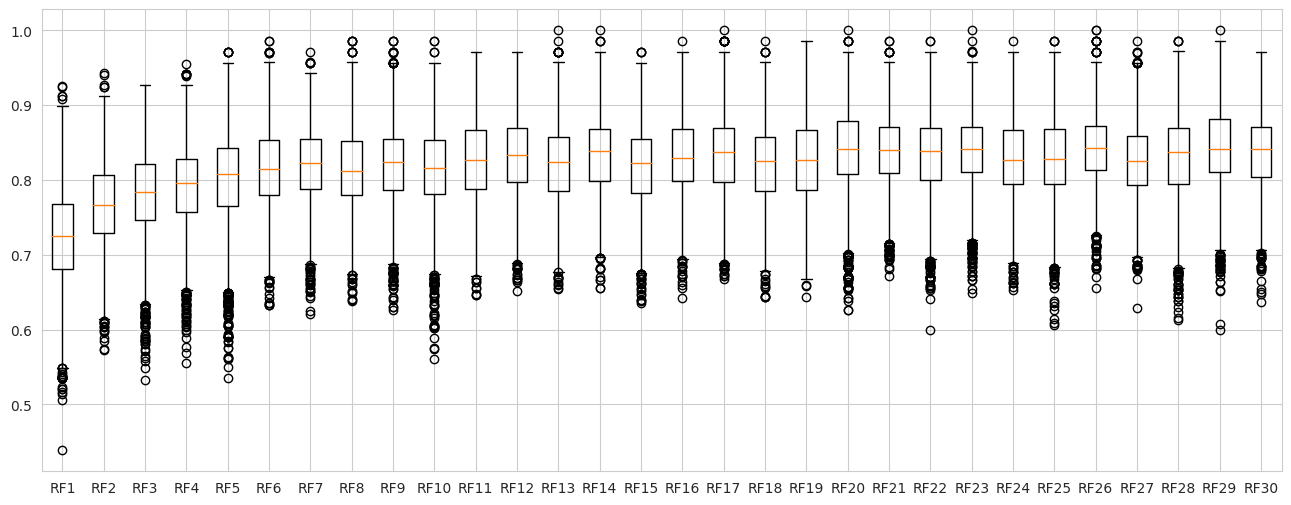

In [82]:
correlations = {}

for n_features in range(1, 31):
    clf = RandomForestClassifier(max_features=n_features, n_jobs=-1)
    clf.fit(X_train, y_train)
    correlations[f"RF{n_features}"] = base_model_pair_correlation(clf, X_test)

plt.figure(figsize=(16,6))
labels, data = [*zip(*correlations.items())]  # 'transpose' items to parallel key, value lists

# or backwards compatable
labels, data = correlations.keys(), correlations.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [83]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

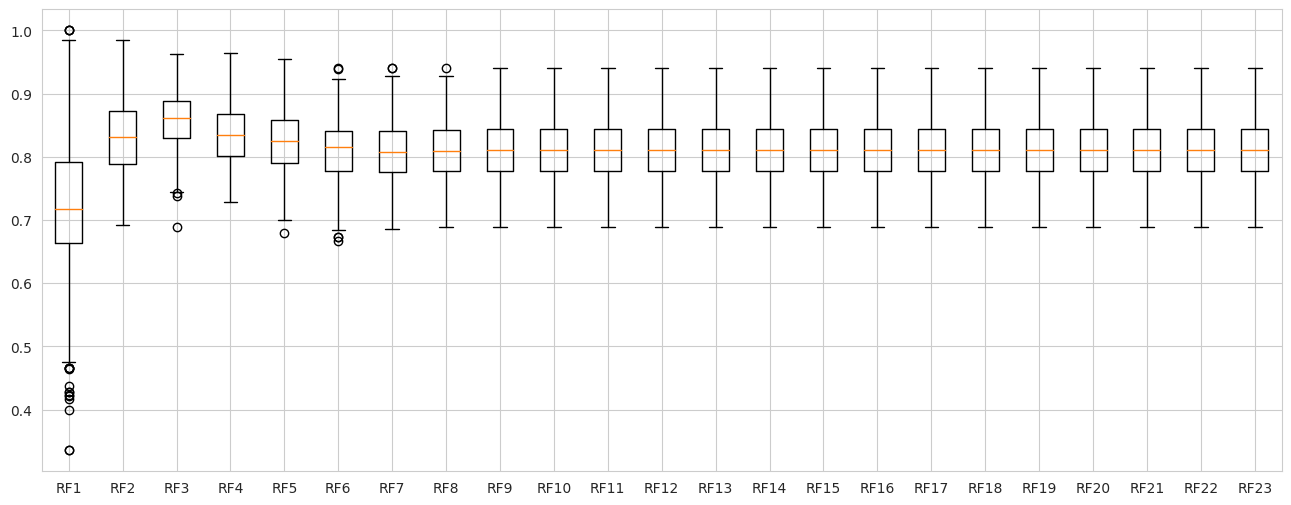

In [79]:
correlations = {}

for depth in range(1, 24):
    clf = RandomForestClassifier(max_depth=depth, n_jobs=-1)
    clf.fit(X_train, y_train)
    correlations[f"RF{depth}"] = base_model_pair_correlation(clf, X_test)

plt.figure(figsize=(16,6))
labels, data = [*zip(*correlations.items())]  # 'transpose' items to parallel key, value lists

# or backwards compatable
labels, data = correlations.keys(), correlations.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

Опишите ваши наблюдения:

* При увеличении фичей корреляция становится сильнее и выходит на плато примерно начиная с `max_features = 5`
* Корреляция при увеличении глубины убывает и затем стабилизируется. При малых значениях глубины очень большой размах корреляции

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [85]:
heart_dataset = pd.read_csv("heart.csv")

In [86]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [186]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf),
               ("ETC", etc), ("KNN", knn),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
               ("CAT", cat), ("LGBM", lgbm),
               ("LGBM_RF", lgbm_rf), ("XGB", xgb),
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [187]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier([(s, clone(x)) for (s, x) in base_models], voting='hard', n_jobs=-1)
voting_soft = VotingClassifier([(s, clone(x)) for (s, x) in base_models], voting='soft', n_jobs=-1)


## END YOUR CODE HERE ##
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]:
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8426829268292683
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [188]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [est[0] for est in ensemble.estimators]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xj_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xj_test)
        corrs.append((base_model_names[i], base_model_names[j], pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [189]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

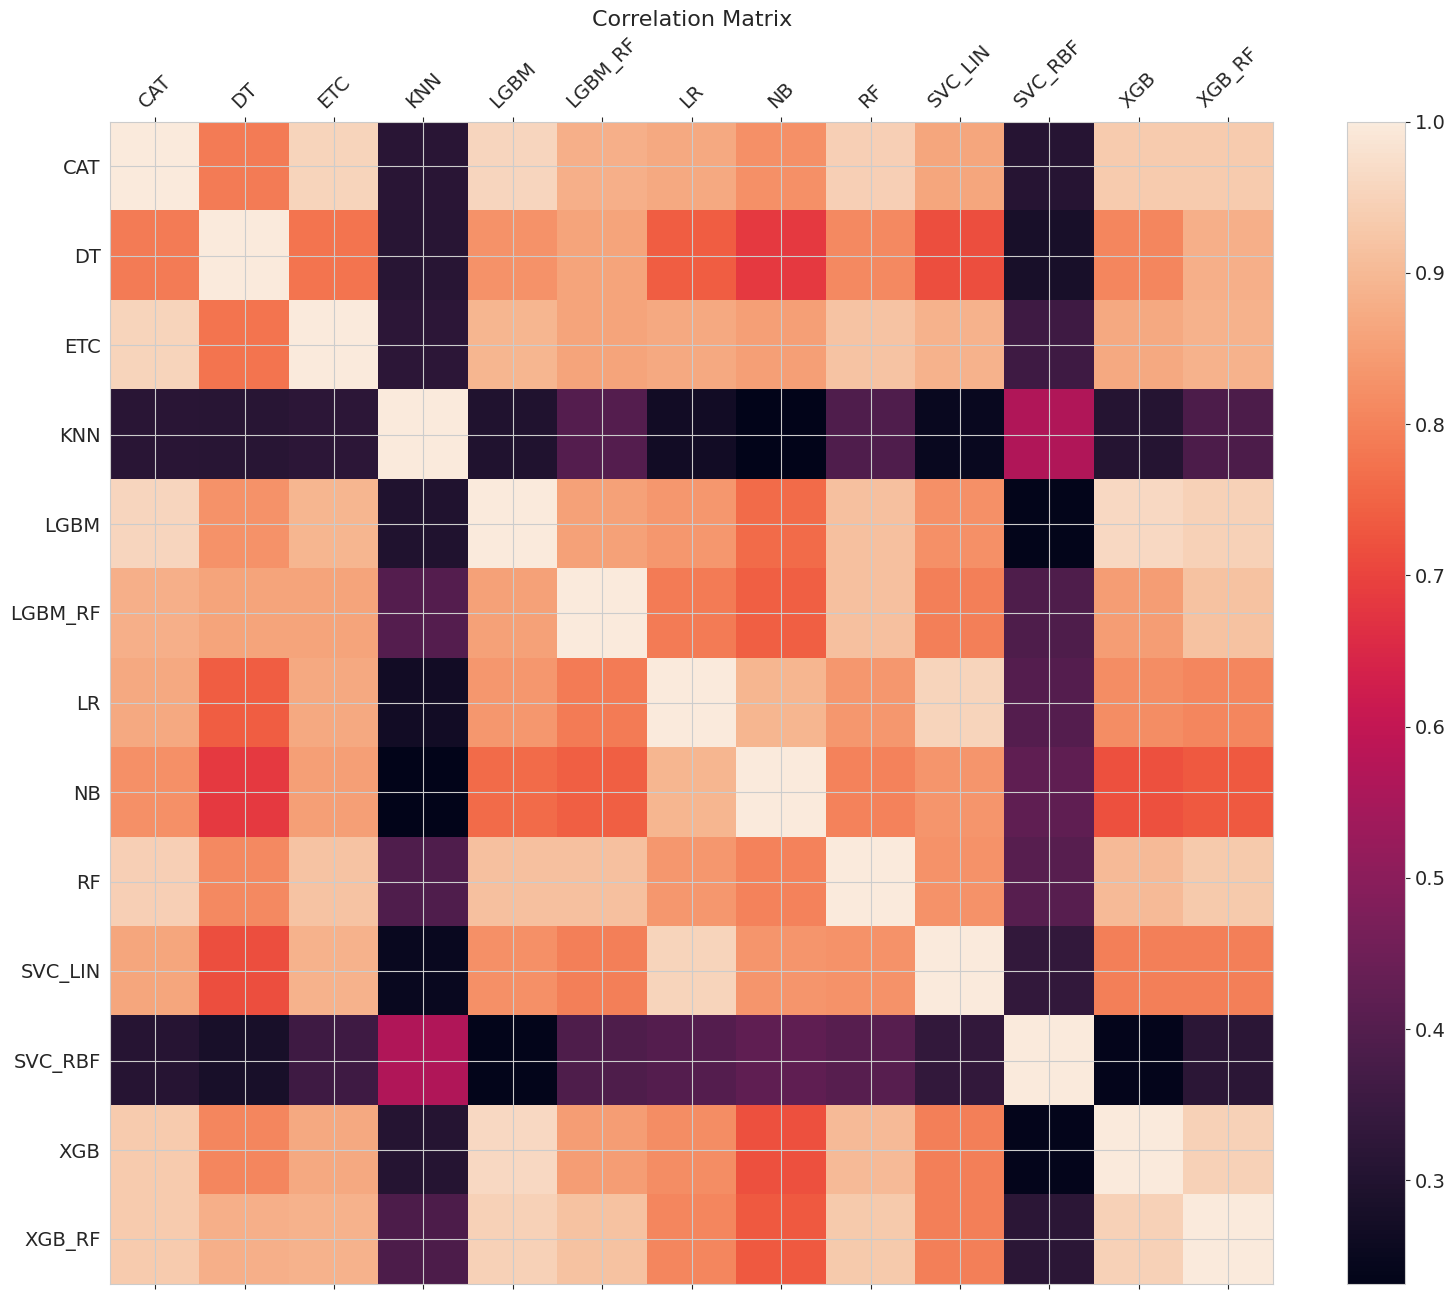

In [190]:
voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)
correlations = base_model_pair_correlation_for_voting_clf(voting_hard, X_test)

tags = []
for t1, t2, _ in correlations:
    tags += [t1, t2]
tags = index = columns = sorted(list(set(tags)))

tags = dict((t, i) for i, t in enumerate(tags))

corrs = np.identity(len(tags))
for t1, t2, corr in correlations:
    corrs[tags[t1]][tags[t2]] = corr
    corrs[tags[t2]][tags[t1]] = corr

df = pd.DataFrame(corrs, index=index, columns=columns)

f = plt.figure(figsize=(19, 15))
plt.matshow(df, fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Переберём все варианты для 3 классификаторов и выберем с наибольшим f1 score.

In [194]:
scores_max = 0

for (i, est1), (j, est2), (k, est3) in combinations(enumerate(base_models), 3):
    base_models_subset = [est1, est2, est3]
    voting_hard = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='hard', n_jobs=-1)
    voting_soft = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='soft', n_jobs=-1)
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    if scores_max < scores_hard.mean():
        print("Score:", scores_hard.mean(), "(", est1[0], est2[0], est3[0], ")")
        scores_max = scores_hard.mean()

Score: 0.8252322163433276 ( DT RF ETC )
Score: 0.8509157509157509 ( DT RF SVC_LIN )
Score: 0.85143994782549 ( DT KNN LR )
Score: 0.8576283154596407 ( DT SVC_LIN LGBM )
Score: 0.8658193543960756 ( DT LGBM LR )


In [195]:
scores_max = 0

for (i, est1), (j, est2), (k, est3), (l, est4) in combinations(enumerate(base_models), 4):
    base_models_subset = [est1, est2, est3, est4]
    voting_hard = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='hard', n_jobs=-1)
    voting_soft = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='soft', n_jobs=-1)
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    if scores_max < scores_hard.mean():
        print("Score:", scores_hard.mean(), "(", est1[0], est2[0], est3[0], est4[0], ")")
        scores_max = scores_hard.mean()

Score: 0.831010881010881 ( DT RF ETC KNN )
Score: 0.8339848034412664 ( DT RF ETC LR )
Score: 0.8360323886639676 ( DT RF KNN NB )
Score: 0.8369120928157073 ( DT RF SVC_LIN CAT )
Score: 0.8470239934095356 ( DT RF SVC_LIN LGBM )
Score: 0.8514080325050789 ( DT RF LGBM_RF LR )
Score: 0.8519288519288519 ( DT KNN XGB_RF NB )
Score: 0.8548861556991638 ( DT LGBM XGB_RF LR )
Score: 0.8553012756493344 ( RF CAT LGBM_RF LR )
Score: 0.8573192239858907 ( RF LGBM_RF XGB_RF LR )


In [196]:
scores_max = 0

for (_, est1), (_, est2), (_, est3), (_, est4), (_, est5) in combinations(enumerate(base_models), 5):
    base_models_subset = [est1, est2, est3, est4, est5]
    voting_hard = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='hard', n_jobs=-1)
    voting_soft = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='soft', n_jobs=-1)
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    if scores_max < scores_hard.mean():
        print("Score:", scores_hard.mean(), "(", est1[0], est2[0], est3[0], est4[0], est5[0], ")")
        scores_max = scores_hard.mean()

Score: 0.8319212665810869 ( DT RF ETC KNN SVC_LIN )
Score: 0.834701492062644 ( DT RF ETC KNN XGB )
Score: 0.8349633905189462 ( DT RF ETC KNN NB )
Score: 0.8387984729756881 ( DT RF ETC SVC_LIN SVC_RBF )
Score: 0.8497527651587546 ( DT RF ETC SVC_LIN LGBM )
Score: 0.854090354090354 ( DT RF ETC SVC_LIN XGB )
Score: 0.8544537122850375 ( DT RF KNN SVC_LIN XGB_RF )
Score: 0.8554264157010735 ( DT RF KNN SVC_LIN LR )
Score: 0.8563725490196078 ( DT RF SVC_LIN SVC_RBF LGBM_RF )
Score: 0.857422888765038 ( DT RF SVC_LIN SVC_RBF XGB_RF )
Score: 0.8623886746503797 ( DT RF SVC_LIN CAT LGBM )
Score: 0.8667872212176011 ( DT RF SVC_LIN LGBM_RF XGB )
Score: 0.8698702857406638 ( DT KNN SVC_LIN SVC_RBF LR )
Score: 0.874723729154109 ( DT SVC_LIN LGBM XGB LR )


In [211]:
scores_max = 0

for (_, est1), (_, est2), (_, est3), (_, est4), (_, est5), (_, est6) in combinations(enumerate(base_models), 6):
    base_models_subset = [est1, est2, est3, est4, est5, est6]
    voting_hard = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='hard', n_jobs=-1)
    voting_soft = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='soft', n_jobs=-1)
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    if scores_max < scores_soft.mean():
        print("Score:", scores_soft.mean(), "(", est1[0], est2[0], est3[0], est4[0], est5[0], est6[0], ")")
        scores_max = scores_soft.mean()

Score: 0.8325977904291157 ( DT RF ETC KNN SVC_LIN SVC_RBF )
Score: 0.8326978801281074 ( DT RF ETC KNN SVC_LIN CAT )
Score: 0.8330443726124009 ( DT RF ETC KNN SVC_LIN LGBM )
Score: 0.8477122329362828 ( DT RF ETC KNN SVC_LIN LGBM_RF )
Score: 0.8541821196387277 ( DT RF ETC KNN SVC_LIN NB )
Score: 0.8667872212176011 ( DT RF ETC SVC_LIN CAT LGBM )
Score: 0.8677170064120969 ( DT SVC_LIN CAT LGBM_RF LR NB )


In [210]:
scores_max = 0

for (_, est1), (_, est2), (_, est3), (_, est4), (_, est5), (_, est6), (_, est7) in combinations(enumerate(base_models), 7):
    base_models_subset = [est1, est2, est3, est4, est5, est6, est7]
    voting_hard = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='hard', n_jobs=-1)
    voting_soft = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='soft', n_jobs=-1)
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    if scores_max < scores_soft.mean():
        print("Score:", scores_soft.mean(), "(", est1[0], est2[0], est3[0], est4[0], est5[0], est6[0], est7[0], ")")
        scores_max = scores_soft.mean()

Score: 0.8373596951910205 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT )
Score: 0.8378306061541628 ( DT RF ETC KNN SVC_LIN SVC_RBF LGBM )
Score: 0.8456737434090648 ( DT RF ETC KNN SVC_LIN SVC_RBF XGB )
Score: 0.8541821196387277 ( DT RF ETC KNN SVC_LIN CAT NB )
Score: 0.8573740941029321 ( DT RF ETC KNN CAT LR NB )
Score: 0.8596149989038618 ( DT RF ETC SVC_LIN SVC_RBF CAT LGBM_RF )
Score: 0.8623886746503797 ( DT RF ETC SVC_LIN CAT LGBM XGB_RF )
Score: 0.8667872212176011 ( DT RF ETC SVC_LIN CAT LGBM_RF XGB )


In [209]:
scores_max = 0

for (_, est1), (_, est2), (_, est3), (_, est4), (_, est5), (_, est6), (_, est7), (_, est8) in combinations(enumerate(base_models), 8):
    base_models_subset = [est1, est2, est3, est4, est5, est6, est7, est8]
    voting_hard = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='hard', n_jobs=-1)
    voting_soft = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='soft', n_jobs=-1)
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    if scores_max < scores_soft.mean():
        print("Score:", scores_soft.mean(), "(", est1[0], est2[0], est3[0], est4[0], est5[0], est6[0], est7[0], est8[0], ")")
        scores_max = scores_soft.mean()

Score: 0.8410765011264569 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT LGBM )
Score: 0.8455110375195781 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT XGB )
Score: 0.8488270855559236 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT NB )
Score: 0.8503633581946834 ( DT RF ETC KNN SVC_LIN SVC_RBF LGBM LR )
Score: 0.8547619047619047 ( DT RF ETC KNN SVC_LIN CAT LGBM LR )
Score: 0.8550197256497287 ( DT RF ETC KNN SVC_LIN CAT LR NB )
Score: 0.8571134354266885 ( DT RF ETC KNN CAT LGBM_RF LR NB )
Score: 0.8583484026522002 ( DT RF ETC SVC_LIN SVC_RBF CAT LGBM LGBM_RF )
Score: 0.862026862026862 ( DT RF ETC SVC_LIN CAT LGBM LGBM_RF XGB )
Score: 0.8667872212176011 ( DT RF ETC SVC_LIN CAT LGBM_RF XGB XGB_RF )


In [208]:
scores_max = 0

for (_, est1), (_, est2), (_, est3), (_, est4), (_, est5), (_, est6), (_, est7), (_, est8), (_, est9) in combinations(enumerate(base_models), 9):
    base_models_subset = [est1, est2, est3, est4, est5, est6, est7, est8, est9]
    voting_hard = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='hard', n_jobs=-1)
    voting_soft = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='soft', n_jobs=-1)
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    if scores_max < scores_soft.mean():
        print("Score:", scores_soft.mean(), "(", est1[0], est2[0], est3[0], est4[0], est5[0], est6[0], est7[0], est8[0], est9[0], ")")
        scores_max = scores_soft.mean()

Score: 0.8471887550200803 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT LGBM LGBM_RF )
Score: 0.8501795715998769 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT LGBM XGB )
Score: 0.8510971055088703 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT LGBM LR )
Score: 0.853160683723441 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT XGB XGB_RF )
Score: 0.8535673737747856 ( DT RF ETC KNN SVC_LIN CAT LGBM LGBM_RF XGB_RF )
Score: 0.8550197256497287 ( DT RF ETC KNN SVC_LIN CAT LGBM_RF LR NB )
Score: 0.8551737994775969 ( DT RF ETC SVC_LIN SVC_RBF CAT LGBM LGBM_RF LR )
Score: 0.8583484026522002 ( DT RF ETC SVC_LIN SVC_RBF CAT LGBM XGB XGB_RF )
Score: 0.8618863640214869 ( DT RF ETC SVC_LIN SVC_RBF CAT LGBM XGB LR )
Score: 0.862026862026862 ( DT RF ETC SVC_LIN CAT LGBM LGBM_RF XGB XGB_RF )
Score: 0.8630952380952381 ( DT RF ETC SVC_LIN CAT LGBM_RF XGB XGB_RF LR )
Score: 0.8662849105887082 ( DT RF SVC_LIN SVC_RBF CAT LGBM LGBM_RF XGB LR )
Score: 0.8666953961071607 ( DT SVC_LIN SVC_RBF CAT LGBM LGBM_RF XGB XGB_RF LR )


In [207]:
scores_max = 0

for (_, est1), (_, est2), (_, est3), (_, est4), (_, est5), (_, est6), (_, est7), (_, est8), (_, est9), (_, est10) in combinations(enumerate(base_models), 10):
    base_models_subset = [est1, est2, est3, est4, est5, est6, est7, est8, est9, est10]
    voting_hard = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='hard', n_jobs=-1)
    voting_soft = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='soft', n_jobs=-1)
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    if scores_max < scores_soft.mean():
        print("Score:", scores_soft.mean(), "(", est1[0], est2[0], est3[0], est4[0], est5[0], est6[0], est7[0], est8[0], est9[0], est10[0], ")")
        scores_max = scores_soft.mean()

Score: 0.8455110375195781 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT LGBM LGBM_RF XGB )
Score: 0.8499808758844903 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT LGBM LGBM_RF XGB_RF )
Score: 0.8512639623750736 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT LGBM LGBM_RF LR )
Score: 0.853160683723441 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT LGBM_RF XGB XGB_RF )
Score: 0.8535431660336342 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT LGBM_RF XGB LR )
Score: 0.8572009557216207 ( DT RF ETC KNN SVC_LIN CAT LGBM LGBM_RF XGB LR )
Score: 0.8580130043985466 ( DT RF ETC KNN SVC_LIN CAT LGBM XGB XGB_RF LR )
Score: 0.862026862026862 ( DT RF ETC SVC_LIN SVC_RBF CAT LGBM LGBM_RF XGB XGB_RF )
Score: 0.8626984126984126 ( DT RF KNN SVC_LIN SVC_RBF CAT LGBM LGBM_RF XGB XGB_RF )
Score: 0.863016936732499 ( DT RF SVC_LIN SVC_RBF CAT LGBM LGBM_RF XGB XGB_RF LR )


In [206]:
scores_max = 0

for (_, est1), (_, est2), (_, est3), (_, est4), (_, est5), (_, est6), (_, est7), (_, est8), (_, est9), (_, est10), (_, est11) in combinations(enumerate(base_models), 11):
    base_models_subset = [est1, est2, est3, est4, est5, est6, est7, est8, est9, est10, est11]
    voting_hard = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='hard', n_jobs=-1)
    voting_soft = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='soft', n_jobs=-1)
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    if scores_max < scores_soft.mean():
        print("Score:", scores_soft.mean(), "(", est1[0], est2[0], est3[0], est4[0], est5[0], est6[0], est7[0], est8[0], est9[0], est10[0], est11[0], ")")
        scores_max = scores_soft.mean()

Score: 0.853160683723441 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT LGBM LGBM_RF XGB XGB_RF )
Score: 0.8550318922749822 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT LGBM LGBM_RF XGB LR )
Score: 0.8580130043985466 ( DT RF ETC KNN SVC_LIN SVC_RBF LGBM LGBM_RF XGB XGB_RF LR )
Score: 0.8583484026522002 ( DT RF ETC KNN SVC_LIN CAT LGBM LGBM_RF XGB XGB_RF LR )
Score: 0.862026862026862 ( DT RF ETC SVC_LIN SVC_RBF CAT LGBM LGBM_RF XGB XGB_RF LR )
Score: 0.8626984126984126 ( DT RF KNN SVC_LIN SVC_RBF CAT LGBM LGBM_RF XGB XGB_RF LR )


In [205]:
scores_max = 0

for (_, est1), (_, est2), (_, est3), (_, est4), (_, est5), (_, est6), (_, est7), (_, est8), (_, est9), (_, est10), (_, est11), (_, est12) in combinations(enumerate(base_models), 12):
    base_models_subset = [est1, est2, est3, est4, est5, est6, est7, est8, est9, est10, est11, est12]
    voting_hard = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='hard', n_jobs=-1)
    voting_soft = VotingClassifier([(s, clone(x)) for (s, x) in base_models_subset], voting='soft', n_jobs=-1)
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    if scores_max < scores_soft.mean():
        print("Score:", scores_soft.mean(), "(", est1[0], est2[0], est3[0], est4[0], est5[0], est6[0], est7[0], est8[0], est9[0], est10[0], est11[0], est12[0], ")")
        scores_max = scores_soft.mean()

Score: 0.8580130043985466 ( DT RF ETC KNN SVC_LIN SVC_RBF CAT LGBM LGBM_RF XGB XGB_RF LR )


Честно в начале пыталась выкинуть наиболее коррелирующие классификаторы, основываясь на correlation matrix. Затем, просто пыталась перебрать все варианты, но выше 0.87 получить не удалось.

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель.

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [30]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


EDA:

Переменная `Phone` является уникальной для каждого ряда, поэтому её можно выкинуть из данных.

In [31]:
data = data.drop('Phone', axis=1)
data.shape

(3333, 20)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Int'l Plan      3333 non-null   object 
 4   VMail Plan      3333 non-null   object 
 5   VMail Message   3333 non-null   int64  
 6   Day Mins        3333 non-null   float64
 7   Day Calls       3333 non-null   int64  
 8   Day Charge      3333 non-null   float64
 9   Eve Mins        3333 non-null   float64
 10  Eve Calls       3333 non-null   int64  
 11  Eve Charge      3333 non-null   float64
 12  Night Mins      3333 non-null   float64
 13  Night Calls     3333 non-null   int64  
 14  Night Charge    3333 non-null   float64
 15  Intl Mins       3333 non-null   float64
 16  Intl Calls      3333 non-null   int64  
 17  Intl Charge     3333 non-null   f

In [33]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [34]:
data.isnull().sum()

State             0
Account Length    0
Area Code         0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

В данных нет пропущенных значений.

<AxesSubplot: xlabel='State', ylabel='count'>

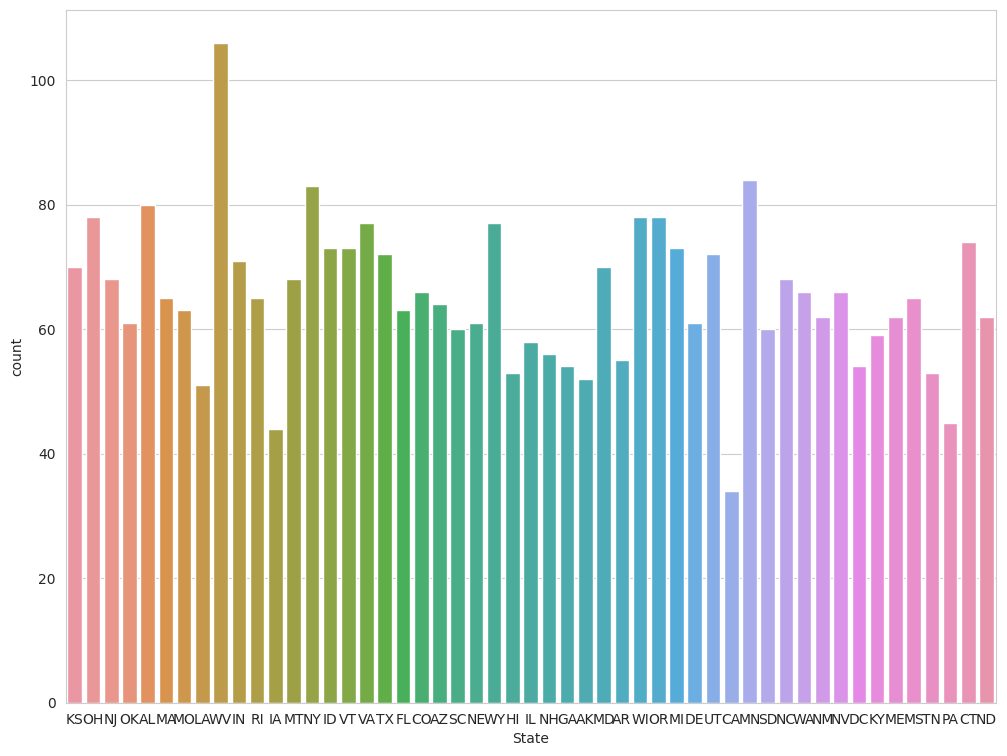

In [35]:
sns.countplot(x=data['State'])

<AxesSubplot: xlabel="Int'l Plan", ylabel='count'>

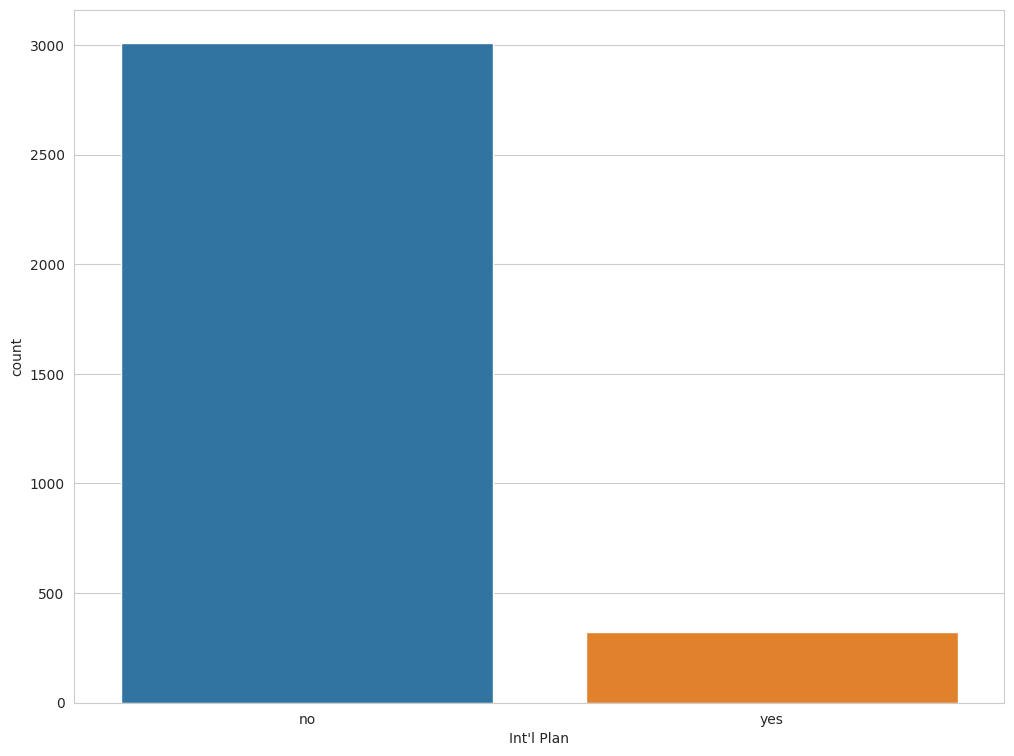

In [36]:
sns.countplot(x=data['Int\'l Plan'])

<AxesSubplot: xlabel='VMail Plan', ylabel='count'>

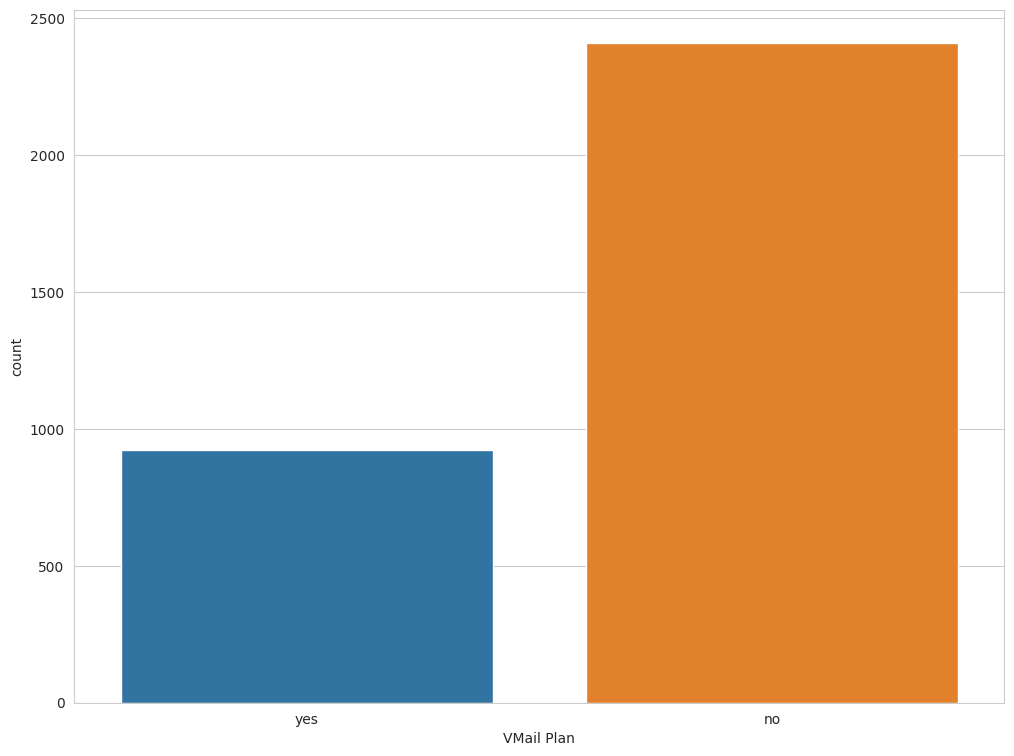

In [37]:
sns.countplot(x=data['VMail Plan'])

<AxesSubplot: xlabel='Churn?', ylabel='count'>

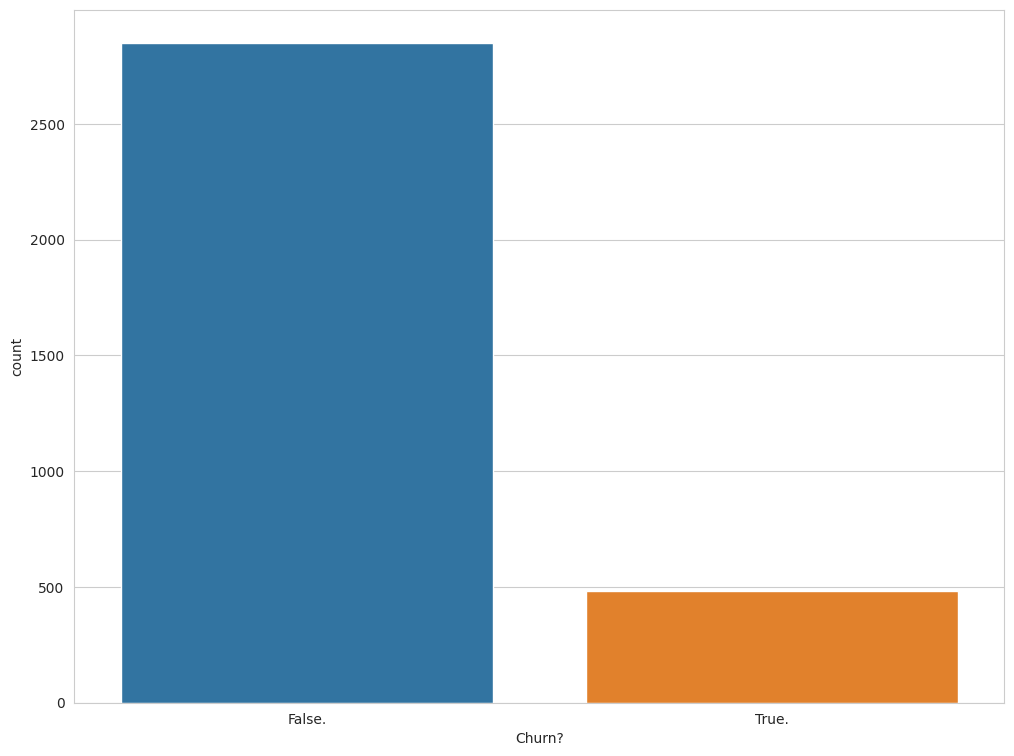

In [38]:
sns.countplot(x=data['Churn?'])

Данные не являются сбалансированными. Поэтому деревья являются более предпочтительными классификаторами.

<function matplotlib.pyplot.show(close=None, block=None)>

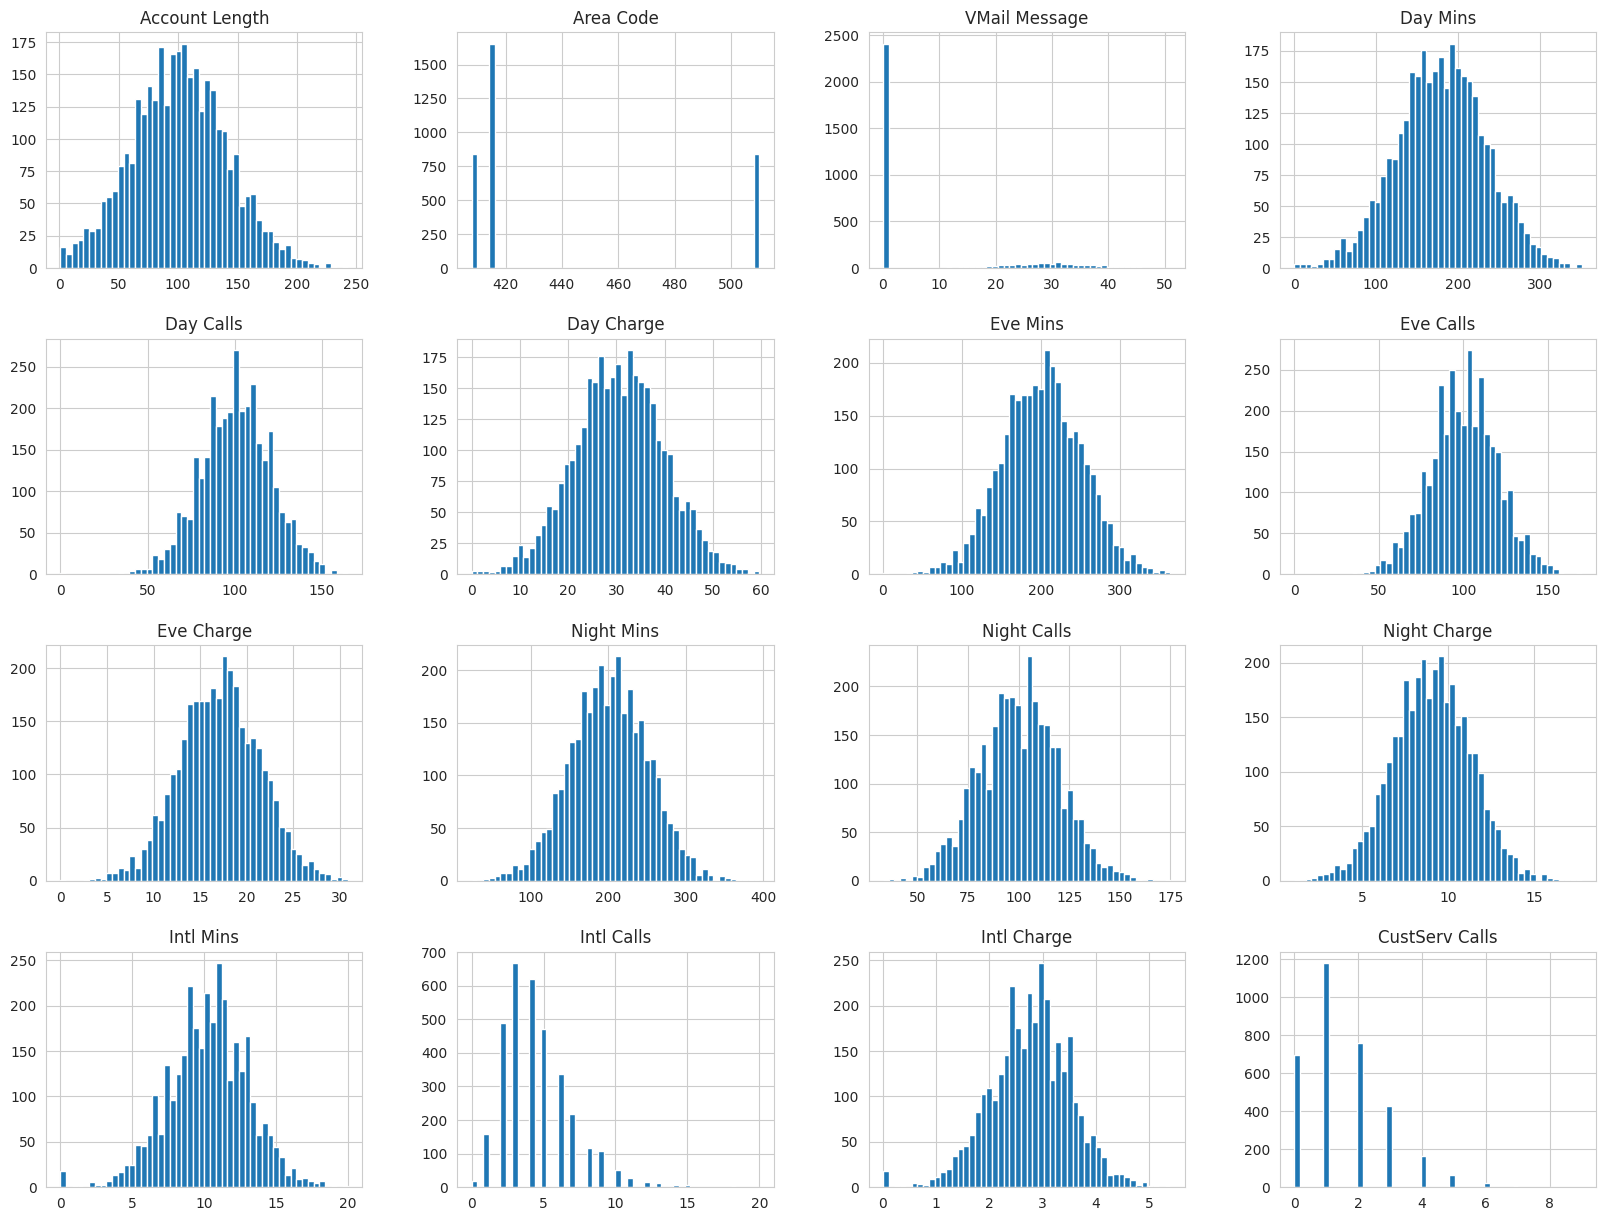

In [39]:
data.hist(bins = 50, figsize = (20,15))
plt.show

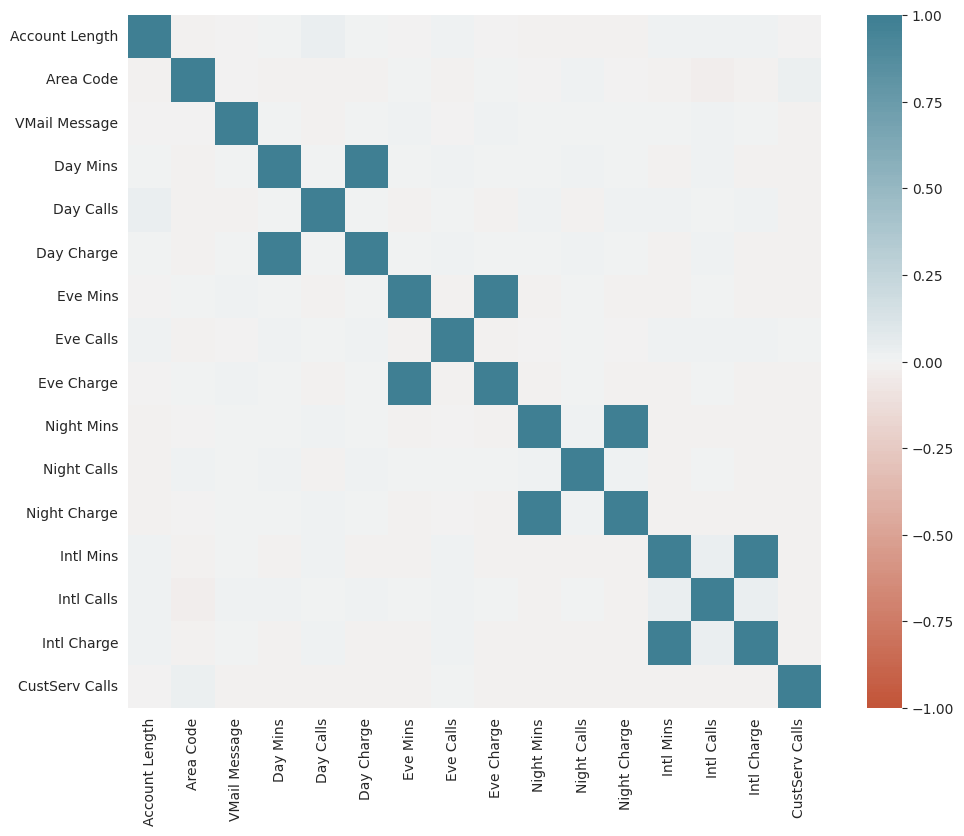

In [40]:
corr_matrix = data.corr()
ax = sns.heatmap(
    corr_matrix,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

Видно, что все переменные `Mins` очень сильно коррелируют с соответствующими переменными `Charge`, поэтому их можно выкинуть из данных для обучения модели.

In [43]:
X = data.drop(['Churn?', 'Day Mins', 'Eve Mins', 'Night Mins', 'Intl Mins'], axis=1)
y = data['Churn?']

Заменим значения `False.` и `True.` на 0 и 1.

In [44]:
y[y == "False."] = 0
y[y == "True."] = 1

In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat = ['State']
bool = [ 'Intl Plan', 'VMail Plan']
num = ['Account Length', 'VMail Message', 'Day Charge', 'Day Calls',
                'Eve Charge', 'Eve Calls',  'Night Charge', 'Night Calls',
                'Intl Charge', 'Intl Calls', 'CustServ Calls']

prepoccessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num),
    ('ohe', OneHotEncoder(), cat)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED)

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

xgbrf = xgboost.XGBRFClassifier(random_state=SEED, n_jobs=-1)
xgbrf_pipeline = make_pipeline(prepoccessor, xgbrf)
xgbrf_pipeline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                    ['Account Length', 'VMail Message',
                                     'Day Charge', 'Day Calls', 'Eve Charge',
                                     'Eve Calls', 'Night Charge', 'Night Calls',
                                     'Intl Charge', 'Intl Calls',
                                     'CustServ Calls']),
                                   ('ohe', OneHotEncoder(), ['State'])])),
  ('xgbrfclassifier',
   XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bytree=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, max_bin=None,
                   max_cat

In [85]:
xgbrf_grid = {
    'xgbrfclassifier__learning_rate': [0.1, 0.5, 1.0, 5.0],
    'xgbrfclassifier__reg_lambda': [1e-06, 1e-05, 1e-04],
    'xgbrfclassifier__n_estimators': [1, 10, 100, 1000],
    'xgbrfclassifier__max_depth': [1, 5, 10, 50],
    'xgbrfclassifier__max_leaves': range(20, 200, 40)
}

gs_xgbrf = GridSearchCV(xgbrf_pipeline, param_grid=xgbrf_grid)
gs_xgbrf.fit(X_train, y_train.astype('int64'))
print(gs_xgbrf.best_estimator_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Account Length',
                                                   'VMail Message',
                                                   'Day Charge', 'Day Calls',
                                                   'Eve Charge', 'Eve Calls',
                                                   'Night Charge',
                                                   'Night Calls', 'Intl Charge',
                                                   'Intl Calls',
                                                   'CustServ Calls']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['State'])])),
                ('xgbrfclassifier',
                 XGBRFClassifier(base_score=None, booster=None, callb...
                                 grow_policy=None, importan

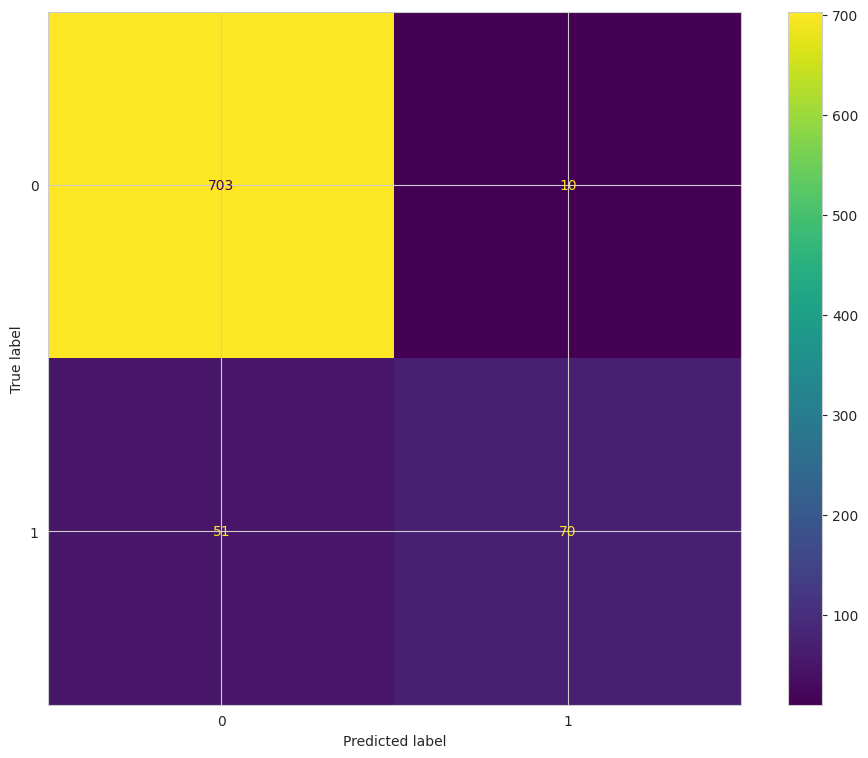

In [86]:
y_pred = gs_xgbrf.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test.astype('int64'), y_pred, labels=gs_xgbrf.best_estimator_.named_steps['xgbrfclassifier'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_xgbrf.best_estimator_.named_steps['xgbrfclassifier'].classes_)
disp.plot()
plt.show()

In [77]:
lgbm = lightgbm.LGBMClassifier(random_state=SEED, n_jobs=-1)
lgbm_pipeline = make_pipeline(prepoccessor, lgbm)
lgbm_pipeline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                    ['Account Length', 'VMail Message',
                                     'Day Charge', 'Day Calls', 'Eve Charge',
                                     'Eve Calls', 'Night Charge', 'Night Calls',
                                     'Intl Charge', 'Intl Calls',
                                     'CustServ Calls']),
                                   ('ohe', OneHotEncoder(), ['State'])])),
  ('lgbmclassifier', LGBMClassifier(random_state=111))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                  ['Account Length', 'VMail Message',
                                   'Day Charge', 'Day Calls', 'Eve Charge',
                                   'Eve Calls', 'Night Charge', 'Night Calls',
                                   'Intl Charge', 'Intl Calls',
         

In [81]:
lgbm_grid = {
    'lgbmclassifier__learning_rate': [0.1, 0.5, 1.0, 5.0],
    'lgbmclassifier__reg_lambda': [1e-06, 1e-05, 1e-04],
    'lgbmclassifier__n_estimators': [1, 10, 100, 1000],
    'lgbmclassifier__max_depth': [1, 5, 10, 50],
    'lgbmclassifier__num_leaves': range(20, 200, 40)
}

gs_lgbm = GridSearchCV(lgbm_pipeline, param_grid=lgbm_grid)
gs_lgbm.fit(X_train, y_train.astype('int64'))
print(gs_lgbm.best_estimator_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Account Length',
                                                   'VMail Message',
                                                   'Day Charge', 'Day Calls',
                                                   'Eve Charge', 'Eve Calls',
                                                   'Night Charge',
                                                   'Night Calls', 'Intl Charge',
                                                   'Intl Calls',
                                                   'CustServ Calls']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['State'])])),
                ('lgbmclassifier',
                 LGBMClassifier(max_depth=50, num_leaves=100, random_state=111,
                                reg_lambda=1e-06))])


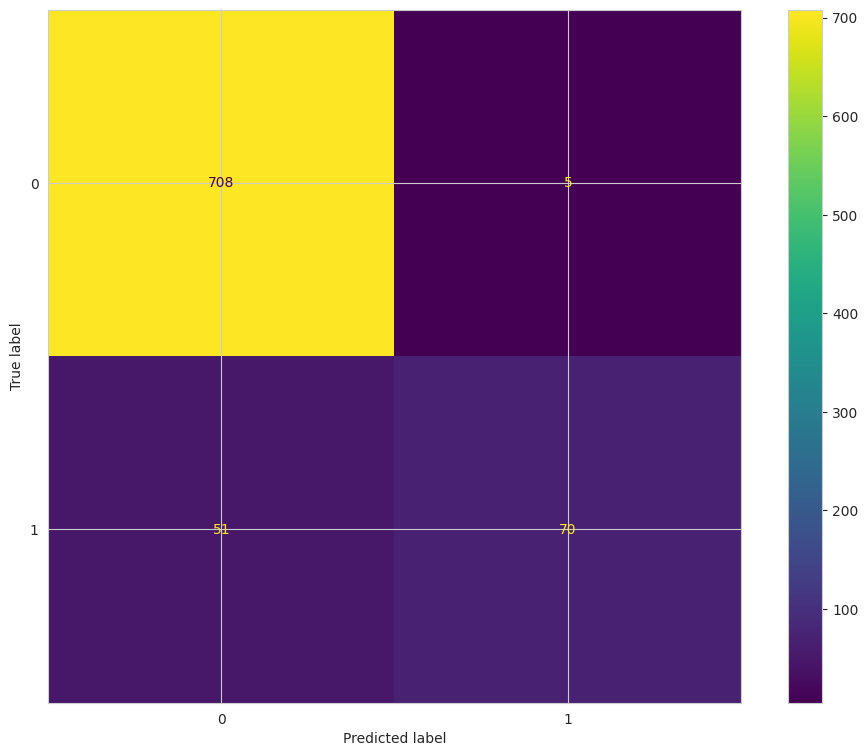

In [83]:
y_pred = gs_lgbm.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test.astype('int64'), y_pred, labels=gs_lgbm.best_estimator_.named_steps['lgbmclassifier'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_lgbm.best_estimator_.named_steps['lgbmclassifier'].classes_)
disp.plot()
plt.show()

LGBMClassifier кластеризовал немного лучше, чем XGBRFClassifier.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [87]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**